In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
import pandas as pd
import numpy as np
import pickle

In [2]:
def mean_shift(p1_embeddings_path, p2_embeddings_path, save_path):
    
    with open(p2_embeddings_path,'rb') as f:
        p2 = pickle.load(f)
        
    with open(p1_embeddings_path,'rb') as f:
        p1 = pickle.load(f)
    
    translation_vector = p2.mean(axis=0) - p1.mean(axis=0)
    
    new_p2 = p1 + translation_vector
    
    with open(save_path,'wb') as f:
        pickle.dump(new_p2, f)
        
    return new_p2

In [101]:
class_name= "Pose1"
old_people_embedding = "old_people_embeddings/" + class_name + ".pkl"
new_people_embedding = "new_person_embeddings/" + class_name + ".pkl"
save_path ="translated_embeddings/" + class_name + ".pkl"
mean_shift(old_people_embedding, new_people_embedding, save_path)

array([[ 0.02945705, -0.0136211 , -0.00314285, ..., -0.03445551,
        -0.0252216 , -0.03226232],
       [ 0.02927005, -0.0138401 , -0.00274885, ..., -0.03477851,
        -0.0251906 , -0.03216632],
       [ 0.03351605, -0.0137591 , -0.00258185, ..., -0.03588551,
        -0.0250366 , -0.03071332],
       ...,
       [ 0.03348305, -0.0138161 , -0.00255485, ..., -0.03557651,
        -0.0246946 , -0.03067432],
       [ 0.03161005, -0.0124991 , -0.00310585, ..., -0.03736551,
        -0.0243986 , -0.03160332],
       [ 0.02909205, -0.0135961 , -0.00312485, ..., -0.03433151,
        -0.0254456 , -0.03234332]])

In [21]:
import model.create_dataset as create_dataset
from model.utils import Params
from model.model_fn import model_fn
import tensorflow as tf

In [22]:
def _get_embeddings(filename, estimator, params):
        
    # Compute embeddings for an image file
    tf.logging.info("Predicting on "+filename)

    predictions = estimator.predict(lambda: _get_dataset(filename, params))

    embeddings = np.zeros((1, params.embedding_size))
    for i, p in enumerate(predictions):
        embeddings[i] = p['embeddings']

    tf.logging.info("Image embedding shape: {}".format(embeddings.shape))

    return embeddings

In [23]:
def _get_dataset(filename, params):

    # A tensor of only one filename
    filename_tensor = tf.constant([filename])

    # Load necessary params from config file
    image_size = params.image_size
    channels = 3 if params.rgb else 1

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(filename_tensor)
    dataset = dataset.map(lambda filename: _parse_function(filename, image_size, channels))
    dataset = dataset.batch(1)

    return dataset

In [24]:
def _parse_function(filename, image_size, channels):
    # Read an image from a file
    # Decode it into a dense vector
    # Resize it to fixed shape
    # Reshape it to 1 dimensional tensor
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=channels)
    image_resized = tf.image.resize_images(image_decoded, [image_size, image_size])
    features = tf.reshape(image_resized, [image_size*image_size*channels])
    features_normalized = features / 255.0
    return features_normalized

In [ ]:
model_dir = "experiments/p1_training"

filename = "New_Pose1/1495.png"

json_path = os.path.join(model_dir, 'params.json')

params = Params(json_path)

tf.reset_default_graph()

config = tf.estimator.RunConfig(tf_random_seed=230,
                                    model_dir=model_dir,
                                    save_summary_steps=params.save_summary_steps)

estimator = tf.estimator.Estimator(model_fn, params=params, config=config)

embeddings = _get_embeddings(filename, estimator, params)

In [26]:
def closest_point(embedding, dictionary):
    shortest_dist = 1000000
    for label,matrix in dictionary.items():
        for i in matrix:
            dist = find_euclidean_distance (embedding,i)
            if (dist < shortest_dist):
                shortest_dist = dist
                index = label
    return shortest_dist, index

In [27]:
def find_euclidean_distance (A,B):
    return np.sqrt(np.sum(np.square(A-B)))

In [31]:
with open("translated_embeddings/Pose1.pkl", "rb") as handle:
    Pose1 = pickle.load(handle)
    
with open("translated_embeddings/Pose2.pkl", "rb") as handle:
    Pose2 = pickle.load(handle)
    
with open("translated_embeddings/Pose3.pkl", "rb") as handle:
    Pose3 = pickle.load(handle)
    
with open("translated_embeddings/Pose4.pkl", "rb") as handle:
    Pose4 = pickle.load(handle)
    
with open("translated_embeddings/Pose5.pkl", "rb") as handle:
    Pose5 = pickle.load(handle)
    
with open("translated_embeddings/Pose6.pkl", "rb") as handle:
    Pose6 = pickle.load(handle)
    
dict_data = {"Pose1":Pose1, "Pose2": Pose1,"Pose3":Pose1, 
             "Pose4": Pose1, "Pose5":Pose1, "Pose6":Pose1 }


In [ ]:
closest_point(embeddings,dict_data)

In [32]:
dict_data["Pose1"].shape

(99, 64)

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [59]:
matrix = np.vstack([Pose1, Pose2, Pose3, Pose4, Pose5, Pose6])
embeggings_lower = TSNE(n_components=2).fit_transform(matrix)
Embedding_data_frame = pd.DataFrame(embeggings_lower)

In [32]:
Pose1_df = pd.DataFrame(Pose1)
Pose1_df["label"] = "Pose1"

Pose2_df = pd.DataFrame(Pose2)
Pose2_df["label"] = "Pose2"

Pose3_df = pd.DataFrame(Pose3)
Pose3_df["label"] = "Pose3"

Pose4_df = pd.DataFrame(Pose4)
Pose4_df["label"] = "Pose4"

Pose5_df = pd.DataFrame(Pose5)
Pose5_df["label"] = "Pose5"

Pose6_df = pd.DataFrame(Pose6)
Pose6_df["label"] = "Pose6"

A = pd.concat([Pose1_df, Pose2_df, Pose3_df, Pose4_df, Pose5_df, Pose6_df ])

In [35]:
embeggings_lower = TSNE(n_components=2).fit_transform(A.drop("label",axis=1))

In [52]:
embeddings_Pose1 = embeggings_lower[A["label"]=="Pose1"]

In [53]:
embeddings_Pose1.shape

(101, 2)

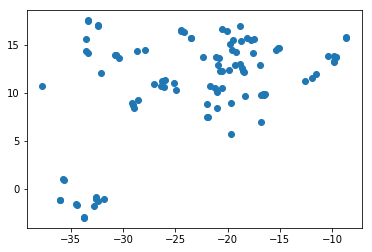

In [54]:
plt.scatter(embeddings_Pose1[:,0], embeddings_Pose1[:,1])

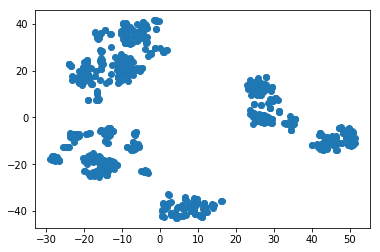

In [55]:
plt.scatter(embeggings_lower[:,0], embeggings_lower[:,1])

In [122]:
embeddings_dir = "base_model_v3_batchall_nounknown/landmarks/"
with open(os.path.join(embeddings_dir, 'embeddings_new_p1.txt'), 'w') as f:
    f.write('label\tfilename\tembeddings\n')
    for i in range(len(A)):
        emb = A.iloc[i,:-1]
        filename = i
        label = A["label"].iloc[i]
        f.write("%s\t%s\t%s\n" %(label, filename, ','.join(map(str,emb))))